In [64]:
import numpy as np
import glob
import pandas as pd
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters
import pickle
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from matplotlib.colors import ListedColormap


In [12]:
# geting list of files in condition and control workers

condition_files = glob.glob('data/condition/*')

control_files = glob.glob('data/control/*')

# reading first files

condition_data = np.genfromtxt(condition_files[0],delimiter=',')

control_data = np.genfromtxt(control_files[0],delimiter=',')

condition_data = condition_data[1:]

control_data = control_data[1:]

# creating fisrt ids

condition_id = [1 for i in range(len(condition_data))]

control_id = [24 for i in range(len(control_data))]

# creating fisrt timestamps

condition_time = [i+1 for i in range(len(condition_data))]

control_time = [i+1 for i in range(len(control_data))]

for i in range(1,len(condition_files)):

    new_entry = np.genfromtxt(condition_files[i],delimiter=',')

    new_entry = new_entry[1:]

    for j in range(len(new_entry)): 
        
        condition_id.append(i+1)

        condition_time.append(j+1)

    condition_data = np.vstack((condition_data,new_entry))

for i in range(1,len(control_files)):

    new_entry = np.genfromtxt(control_files[i],delimiter=',')
    new_entry = new_entry[1:]

    for j in range(len(new_entry)): 
    
        control_id.append(i+24)
    
        control_time.append(j+1)

    control_data = np.vstack((control_data,new_entry))

control_id = np.array(control_id).reshape(-1,1)

control_time = np.array(control_time).reshape(-1,1)

condition_id = np.array(condition_id).reshape(-1,1)

condition_time = np.array(condition_time).reshape(-1,1)


In [20]:
control_array = np.hstack((control_id,control_time,control_data))

condition_array = np.hstack((condition_id,condition_time,condition_data))

complete_data = np.vstack((condition_array,control_array))

df = pd.DataFrame(complete_data, columns= ['id','time','timestamp','date','activity'])


In [79]:
df.head()

,id,time,timestamp,date,activity
0,1.0,1.0,0.0,0.0,5.0
1,1.0,2.0,0.0,0.0,5.0
2,1.0,3.0,0.0,0.0,5.0
3,1.0,4.0,0.0,0.0,5.0
4,1.0,5.0,0.0,0.0,5.0


In [25]:
extract_df = extract_features(df, column_id="id", column_sort="time",
                                default_fc_parameters = EfficientFCParameters(),
                                chunksize=1,
                                n_jobs=4,
                                disable_progressbar=False)

extract_df = impute(extract_df)

Feature Extraction: 100%|██████████| 165/165 [37:17<00:00, 13.56s/it]
/home/thiago/anaconda3/envs/CNPq-3.7/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['timestamp__variation_coefficient' 'timestamp__benford_correlation'
 'timestamp__autocorrelation__lag_0' 'timestamp__autocorrelation__lag_1'
 'timestamp__autocorrelation__lag_2' 'timestamp__autocorrelation__lag_3'
 'timestamp__autocorrelation__lag_4' 'timestamp__autocorrelation__lag_5'
 'timestamp__autocorrelation__lag_6' 'timestamp__autocorrelation__lag_7'
 'timestamp__autocorrelation__lag_8' 'timestamp__autocorrelation__lag_9'
 'timestamp__partial_autocorrelation__lag_1'
 'timestamp__partial_autocorrelation__lag_2'
 'timestamp__partial_autocorrelation__lag_3'
 'timestamp__partial_autocorrelation__lag_4'
 'timestamp__partial_autocorrelation__lag_5'
 'timestamp__partial_autocorrelation__lag_6'
 'timestamp__partial_autocorrelation__lag_7'
 'timestamp__partial_autocorrelation__lag_

In [31]:
pickle.dump( extract_df, open( "extract_df.pkl", "wb" ) )

In [30]:
target = np.zeros((55))

target[:23] = 1

filtered_features = select_features(extract_df, target,n_jobs=0)

pickle.dump( filtered_features, open( "filtered_features.pkl", "wb" ) )


In [73]:
filtered_features = pickle.load( open( "filtered_features.pkl", "rb" ) )

In [81]:
filtered_features.shape

(55, 47)

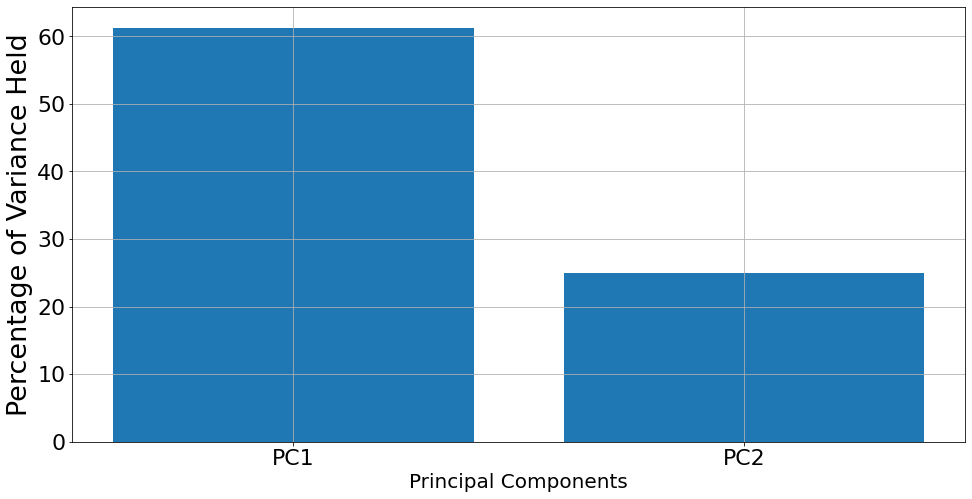

In [74]:
N_PCs = 2

#centralizar os dados e colocá-los com desvioPadrão=1

scaler = StandardScaler().fit(filtered_features)

features_padronizadas = scaler.transform(filtered_features)

pca= PCA(n_components = N_PCs)

pca.fit(features_padronizadas)


variacao_percentual_pca = np.round(pca.explained_variance_ratio_ * 100, decimals = 2)

fig = plt.figure(figsize=[16,8])

ax = fig.subplots(1,1)

ax.bar(x=['PC' + str(x) for x in range(1,(N_PCs+1))],height=variacao_percentual_pca[0:N_PCs])

ax.set_ylabel('Percentage of Variance Held',fontsize=27)
ax.set_xlabel('Principal Components',fontsize=20)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.grid()
plt.show()
fig.savefig('PCA.png', bbox_inches='tight')

reduced_features = pca.transform(features_padronizadas)


In [83]:
sum(variacao_percentual_pca)

86.21000000000001

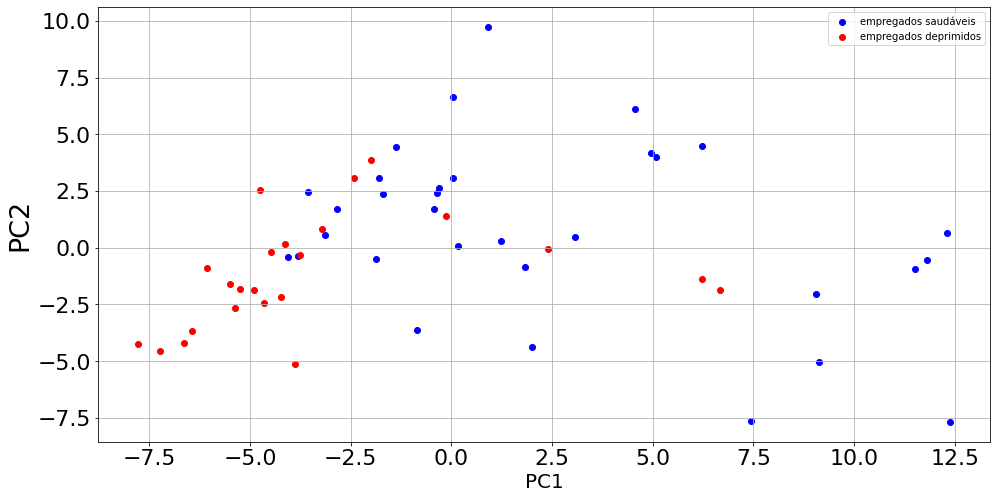

In [75]:
fig = plt.figure(figsize=[16,8])

ax = fig.subplots(1,1)

ax.scatter(reduced_features[target==0,0],
            reduced_features[target==0,1],
            color='blue',
            label = 'empregados saudáveis')

ax.scatter(reduced_features[target==1,0],
            reduced_features[target==1,1],
            color='red',
            label = 'empregados deprimidos')

ax.set_ylabel('PC2',fontsize=27)
ax.set_xlabel('PC1',fontsize=20)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.grid()
ax.legend()
plt.show()
fig.savefig('PCA_scatter.png', bbox_inches='tight')


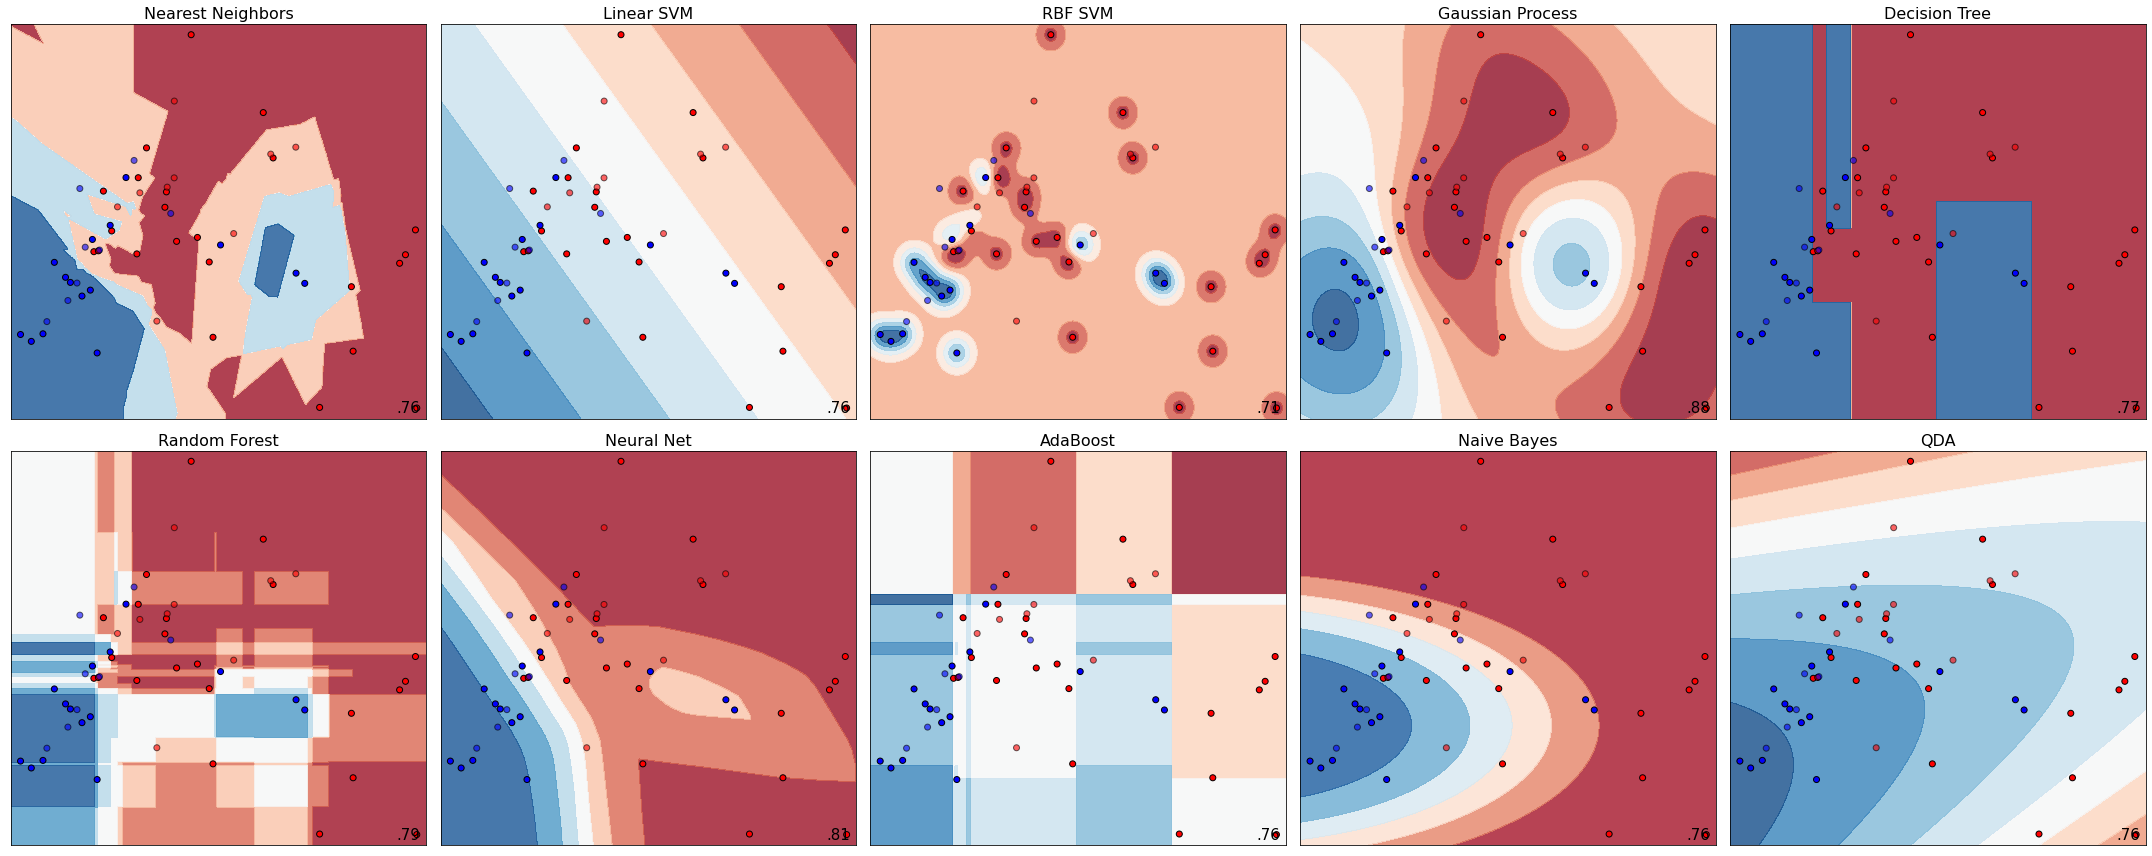

In [87]:
h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)

X += 2 * rng.uniform(size=X.shape)

linearly_separable = (X, y)

figure = plt.figure(figsize=(30, 12))


# preprocess dataset, split into training and test part

X = reduced_features

y = target

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size = 0.3, random_state = 42

)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5

y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# just plot the dataset first

cm = plt.cm.RdBu

cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# iterate over classifiers

for i,(name, clf) in enumerate(zip(names, classifiers)):

    score = []

    for j in range(33):
        
        X = reduced_features

        y = target

        X_train, X_test, y_train, y_test = train_test_split(

            X, y, test_size=0.3, random_state=42

        )

        clf.fit(X_train, y_train)

        score.append(clf.score(X_test, y_test))

    score = np.mean(score)

    ax = plt.subplot(2, 5, i+1)

    clf.fit(X_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each

    # point in the mesh [x_min, x_max]x[y_min, y_max].

    if hasattr(clf, "decision_function"):

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    else:

        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot

    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

    # Plot the training points
    
    ax.scatter(

        X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"

    )

    # Plot the testing points

    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(xx.min(), xx.max())

    ax.set_ylim(yy.min(), yy.max())

    ax.set_xticks(())

    ax.set_yticks(())

    ax.set_title(name,fontdict={'fontsize': 16})

    ax.text(
        xx.max() - 0.3,
        yy.min() + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    i += 1

plt.tight_layout()

plt.show()

figure.savefig('classification_results.png', bbox_inches='tight')